In [1]:
import os
import pandas as pd
from glob import glob
import json
import rdkit.Chem as Chem
from rdkit.Chem import PandasTools
from rdkit.Chem import Descriptors, Lipinski

In [50]:
def read_osra_result(path):
    d = {}
    for line in open(path):
        line = line.strip()
        if line:
            cid, smi = line.split("\t")
            d[cid.lower()] = smi
    return d

def calcMolAttr(smiles):
    m = Chem.MolFromSmiles(smiles)
    m = Chem.AddHs(m)
    return [round(Descriptors.MolWt(m)),
            len(m.GetAtoms()),
            Descriptors.HeavyAtomCount(m),
            Lipinski.RingCount(m),
            Lipinski.NumRotatableBonds(m),
            Lipinski.NumAromaticRings(m),
            Descriptors.NumHAcceptors(m),
            Descriptors.NumHDonors(m),
            Descriptors.TPSA(m),
            Descriptors.MolLogP(m),
            0, 0, 0
            ]
attributes = [
    "MW",
    "Atoms",
    "HeavyAtom",
    "RotateBond",
    "RingCount",
    "AromaticRing",
    "HBA",
    "HBD",
    "TPSA",
    "cLogP",
    "cLogD",
    "cLogS",
    "pKa"
]

In [86]:
df = pd.read_csv("../jmc-article.txt", sep='\t',
                 header=None, names=["doi", "y", "h", "w", "subtype", "venue"])

def check_column_type(name):
    name = name.lower()
    if name in ["compound", "compd", "cmpd", "cpd", "compd.", "id", "entry"]:
        return "ID"
    elif 0 < len(name) <= 2 and name[0] in ("R", "r"):
        return "R"
    else:
        return name 

database = {}
for doi in df.doi:
    cpd_path = f"../data/{doi}.compounds.txt"
    doc_path = f"../data/{doi}.document.json"
    tbl_path = f"../data/{doi}.json"
    
    if not os.path.exists(cpd_path):
        continue
        
    doc, tables, compounds = json.load(open(doc_path)), json.load(open(tbl_path)), read_osra_result(cpd_path)
    
    for tbl in tables:
        comps, d, h = {}, tbl["content"], tbl["content"][0]
        
        col_type = []
        for j,c in enumerate(h):
            name = c.split(";")[0].lower()
            col_type.append(check_column_type(name))
        
        for i in range(1, len(d)):
            ids, attrs = [], {}
            for j,c in enumerate(col_type):
                if c == "R" or not c:
                    continue
                if c == "ID" and d[i][j]:
                    ids.append(d[i][j])
                else:
                    attrs[c] = d[i][j]
            for cid in ids:
                if compounds.get(cid, None):
                    comps[cid] = attrs
        tbl["compounds"] = comps
    doc.update({"compounds": compounds, "tables": tables})
    database[doi] = doc

,ID,SMILES,MW,Atoms,HeavyAtom,RotateBond,RingCount,AromaticRing,HBA,HBD,TPSA,cLogP,cLogD,cLogS,pKa
0,2a,,435,41,24,3,5,2,5,2,84.22,4.31060,0,0,0
1,2i,,421,38,23,3,5,2,5,2,84.22,3.92050,0,0,0
2,2b,,429,35,24,3,5,3,5,2,84.22,3.79460,0,0,0
3,2j,,422,37,23,3,5,2,6,3,96.25,2.33980,0,0,0
4,2c,,497,38,28,3,5,3,5,2,84.22,4.81340,0,0,0
5,2k,,407,35,22,3,6,2,5,2,84.22,3.21540,0,0,0
6,2d,,423,40,23,2,9,2,5,2,84.22,3.85150,0,0,0
7,2e,,447,42,25,4,7,2,5,2,84.22,4.16650,0,0,0
8,2m,,435,41,24,3,6,2,5,2,84.22,3.99560,0,0,0
9,2f,,395,34,21,2,7,2,5,2,84.22,3.38630,0,0,0

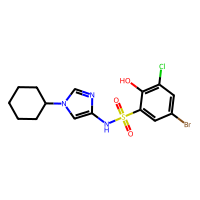
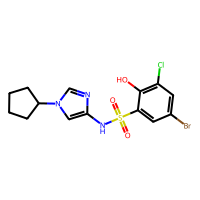
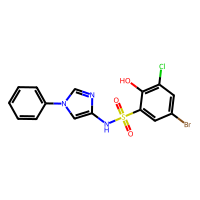
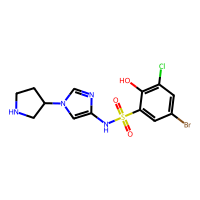
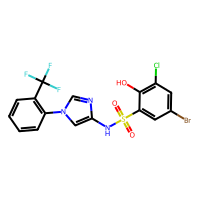
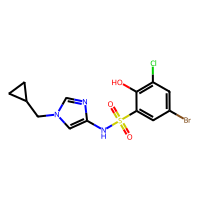
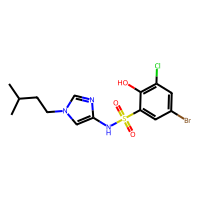
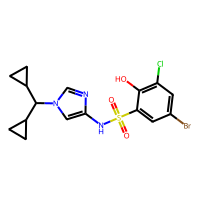
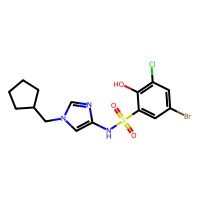
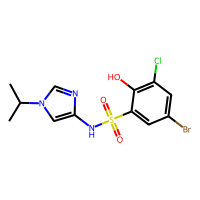
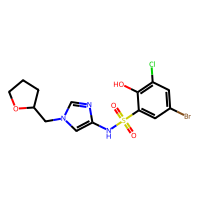
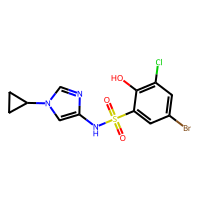
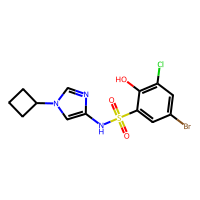
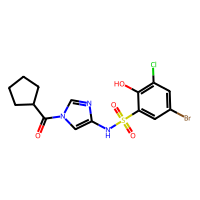
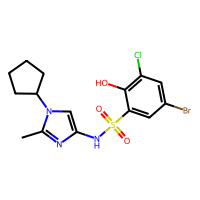
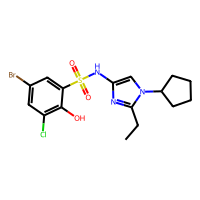
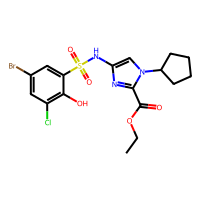
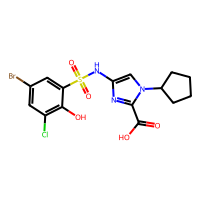
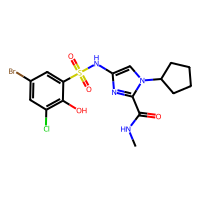
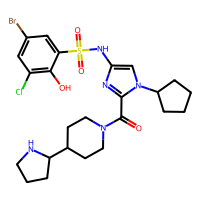
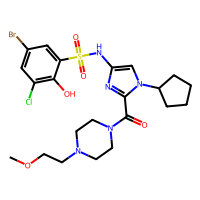
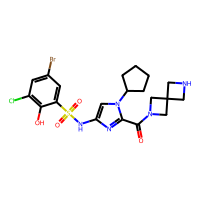
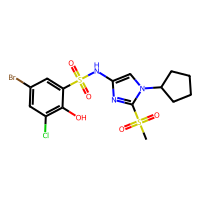

In [85]:
def render(doi, draw_mol=False):
    doc = database[doi]
    data = []
    for tbl in doc["tables"]:
        for cid, attrs in tbl["compounds"].items():
            smi = doc["compounds"][cid]
            values = calcMolAttr(smi)
            data.append([cid, smi] + values)
    d = pd.DataFrame(data, columns=["ID", "SMILES"] + attributes)
    if draw_mol:
        PandasTools.AddMoleculeColumnToFrame(d, 'SMILES','SMILES')
    return d
render('acs.jmedchem.0c00224', True)

In [93]:
output = open("compounds.to-pka.csv", "w")
for doi, doc in database.items():
    for cid, smiles in doc["compounds"].items():
        if len(cid) < 5:
            print(f"{doi}.{cid}\t{smiles}", file=output)
output.close()